In [4]:
import sys

# adding Folder_2 to the system path
#sys.path.insert(0, '/Users/lisadang/Desktop/Github/SPCA')

# path to astro_models
sys.path.insert(0, '/Users/alexandrarochon/Programming/LHS1140-Eureka/myAnalysis')
import astro_models
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import batman
import emcee
import astropy
from astropy.time import Time
import h5py
import corner
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from multiprocessing import Pool
import matplotlib.ticker as mticker
from mc3.stats import time_avg
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support
import matplotlib.patches as patches
from scipy.optimize import curve_fit


In [27]:
eclipses = ['1', '2', '3']
a = '5'
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time_arr = {e: [] for e in eclipses}
aplev_arr = {e: [] for e in eclipses}
aperr_arr = {e: [] for e in eclipses}
centroid_x_arr = {e: [] for e in eclipses}
centroid_y_arr = {e: [] for e in eclipses}

for e in eclipses:
    for seg in segments:
        if e == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+e+'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+e+'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+e+'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[e] = np.append(time_arr[e], np.array(file['time']))
            aplev_arr[e] = np.append(aplev_arr[e], np.array(file['aplev']))
            aperr_arr[e] = np.append(aperr_arr[e], np.array(file['aperr']))
            centroid_x_arr[e] = np.append(centroid_x_arr[e], np.array(file['centroid_x']))
            centroid_y_arr[e] = np.append(centroid_y_arr[e], np.array(file['centroid_y']))

    time_arr[e] = np.array(time_arr[e])
    aplev_arr[e] = np.array(aplev_arr[e])
    aperr_arr[e] = np.array(aperr_arr[e])
    centroid_x_arr[e] = np.array(centroid_x_arr[e])
    centroid_y_arr[e] = np.array(centroid_y_arr[e])
    
print(time_arr['1'])

[60275.77646891 60275.77659717 60275.77672543 ... 60275.93794689
 60275.93807515 60275.93820341]


In [ ]:
# eclipses = ['1', '2', '3']
# segments = ['0000', '0001', '0002', '0003', '0004']

# # Initialize dictionaries to hold arrays for each aperture
# time_arr = {e: [] for e in eclipses}
# aplev_arr = {e: [] for e in eclipses}
# aperr_arr = {e: [] for e in eclipses}
# centroid_x_arr = {e: [] for e in eclipses}
# centroid_y_arr = {e: [] for e in eclipses}


# for e in eclipses:
#     for seg in segments:
#         if e == '1':
#             path = '/lisadang/Desktop/LHS1140c/DataAnalysis/JWST/LHS1140_good/Stage3/S3_2024-06-25_lhs1140c_run1/ap5__bg12_30/S3_lhs1140c_ap5_bg12_30_FluxData_seg'+seg+'.h5'
#         elif e == '2':
#             path = '/lisadang/Desktop/LHS1140c/DataAnalysis/JWST/LH1140_eclipse2/Stage3/S3_2024-07-22_lhs1140c_run1/ap5_bg12_30/S3_lhs1140c_ap5_bg12_30_FluxData_seg'+seg+'.h5'
#         elif e == '3':
#             path = '/lisadang/Desktop/LHS1140c/DataAnalysis/JWST/LH1140_eclipse3/Stage3/S3_2024-08-05_lhs1140c_run1/ap5_bg12_30/S3_lhs1140c_ap5_bg12_30_FluxData_seg'+seg+'.h5'
#         with h5py.File(path, 'r') as file:     # open the file
#             time_arr[e] = np.append(time_arr[e], np.array(file['time']))
#             aplev_arr[e] = np.append(aplev_arr[e], np.array(file['aplev']))
#             aperr_arr[e] = np.append(aperr_arr[e], np.array(file['aperr']))
#             centroid_x_arr[e] = np.append(centroid_x_arr[e], np.array(file['centroid_x']))
#             centroid_y_arr[e] = np.append(centroid_y_arr[e], np.array(file['centroid_y']))

#     time_arr[e] = np.array(time_arr[e])
#     aplev_arr[e] = np.array(aplev_arr[e])
#     aperr_arr[e] = np.array(aperr_arr[e])
#     centroid_x_arr[e] = np.array(centroid_x_arr[e])
#     centroid_y_arr[e] = np.array(centroid_y_arr[e])
    
# print(time_arr['1'])

In [118]:
time = {e: [] for e in eclipses}
aplev = {e: [] for e in eclipses}
aperr = {e: [] for e in eclipses}
centroid_x = {e: [] for e in eclipses}
centroid_y = {e: [] for e in eclipses}

# Remove the first two elements of each array 
for e in eclipses:
    time[e] = time_arr[e][2:]
    aplev[e] = aplev_arr[e][2:]
    aperr[e] = aperr_arr[e][2:]
    centroid_x[e] = centroid_x_arr[e][2:]
    centroid_y[e] = centroid_y_arr[e][2:]


In [119]:
eclipse_times = {'1': Time('2023-11-27 21:00', format='iso', scale='tdb'), '2': Time('2024-07-07 18:34', format='iso', scale='tdb'), '3': Time('2024-07-19 02:34', format='iso', scale='tdb')}  
#e1 = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
# t_s = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
# t_s = Time('2024-07-19 02:34', format = 'iso', scale = 'tdb') # eclipse 3

for e in eclipses:
    eclipse_times[e] = eclipse_times[e].mjd
    time[e] = time[e] - eclipse_times[e]
    aperr[e] = aperr[e] / np.mean(aplev[e])
    aplev[e] = aplev[e] / np.mean(aplev[e])
    time[e] = time[e] * 24
    #eclipse = (eclipse - time_arr[e][0])*24


Text(0, 0.5, 'Normalized Flux')

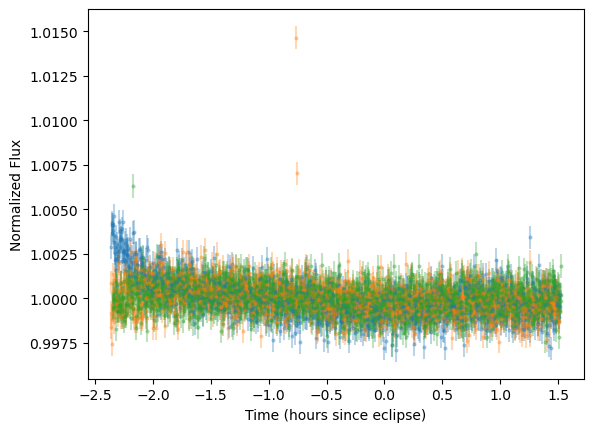

In [36]:
plt.figure()
for e in eclipses: 
    plt.errorbar(time[e], aplev[e], yerr=aperr[e],markersize=2, alpha=0.3, fmt='o')

plt.xlabel('Time (hours since eclipse)')
plt.ylabel('Normalized Flux')

In [54]:
transit = Time('2458389.293900', format = 'jd', scale = 'tdb')
transit = transit.mjd
transit = transit - eclipse_times['1']*24
print(transit)

-1388232.2061


In [51]:
def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters

    params.t0 = transit
    params.per = 3.777940*24                 #orbital period in hours
    params.rp = 0.0539                   #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def exponential_func(x, a, b, c):
    #x = (x - x[0])*24
    return a * np.exp(-b * x) + c

def poly_3rd_degree(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):

    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

In [38]:
chain = {e: [] for e in eclipses}
lnprobchain = {e: [] for e in eclipses}
pos2 = {e: [] for e in eclipses}
prob = {e: [] for e in eclipses}
p0_mcmc = {e: [] for e in eclipses}

for e in eclipses:
    if e == '1':
        savepath = 'MCMC_results/ecl1_exp_'
    else:
        savepath = 'MCMC_results/e'+e+'_'    
    pathchain = savepath+'samplerchain_10000.npy'
    pathlnlchain = savepath+'samplerlnlchain_10000.npy'
    pathposit = savepath+'samplerposi_10000.npy'
    pathlnpro = savepath+'samplerlnpr_10000.npy'

    chain[e] = np.load(pathchain)
    lnprobchain[e] = np.load(pathlnlchain)
    pos2[e] = np.load(pathposit)
    prob[e] = np.load(pathlnpro)
    maxk, maxiter = np.unravel_index((lnprobchain[e]).argmax(), (lnprobchain[e]).shape)   
    p0_mcmc[e] = chain[e][maxk, maxiter,:] 

In [134]:
samples = {e: [] for e in eclipses}
MCMC_Results = {e: [] for e in eclipses}

for e in eclipses:
    # if e == '1':
    #     ndim = 6
    # elif e == '2' or e == '3':
    #     ndim = 9
    ndim = len(p0_mcmc[e])
    samples[e] = chain[e].reshape((-1, ndim))
    MCMC_Results[e] = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples[e], [16, 50, 84],axis=0)))))


In [239]:
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

nbin = 50

bins_time = {e: [] for e in eclipses}
binErr_t = {e: [] for e in eclipses}
bins_centroid_x = {e: [] for e in eclipses}
binErr_centroid_x = {e: [] for e in eclipses}
bins_centroid_y = {e: [] for e in eclipses}
binErr_centroid_y = {e: [] for e in eclipses}

for e in eclipses:
    bins_time[e], binErr_t[e] = binValues(time[e], time[e], nbin)
    bins_centroid_x[e], binErr_centroid_x[e] = binValues(centroid_x[e], time[e], nbin)
    bins_centroid_y[e], binErr_centroid_y[e] = binValues(centroid_y[e], time[e], nbin)
    #bins_time[e] = bins_time[e] - time[e][0]

In [240]:
def binValues(values, error, binAxisValues, nbin, assumeWhiteNoise=True):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binCounts = np.array([np.sum(digitized == i) for i in range(1, nbin)])

    binnedErr = np.array([np.mean(error[digitized == i]) for i in range(1, nbin)])/np.sqrt(binCounts)
    #binnedErr = np.array([np.sqrt(np.sum((error[digitized == i])**2))/(binCounts)  for i in range(1, nbin)]) 
    #binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))

    return binned, binnedErr

bins_aplev = {e: [] for e in eclipses}
binErr_aplev = {e: [] for e in eclipses}

for e in eclipses:
    bins_aplev[e], binErr_aplev[e] = binValues(aplev[e], aperr[e], time[e], nbin)


In [144]:
print(MCMC_Results['1'][0])
print(MCMC_Results['2'][0])
print(MCMC_Results['3'][0])

[2.31956482 0.04519281 0.05262025]
[2.25750115 0.04878117 0.05547599]
[2.25427769 0.04200533 0.14788047]


0.0034969910798945828 2.200738718327359 0.9993481256573673
2.2800010109545807


(0.999, 1.0015)

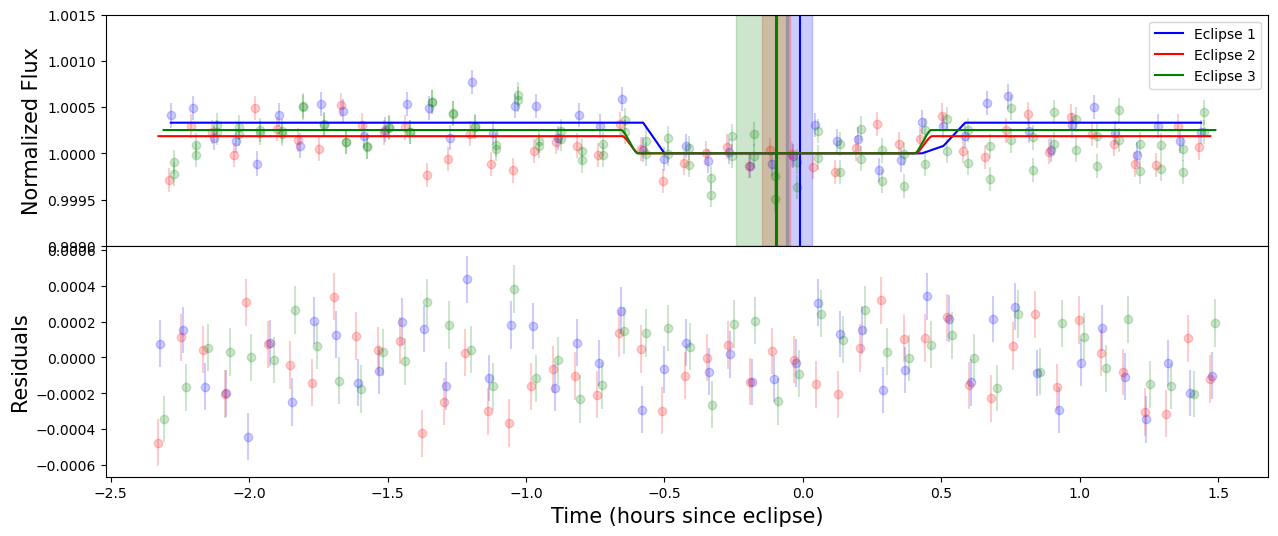

In [241]:
colors = {'1': 'blue', '2': 'red', '3': 'green'}  
astro = {e: [] for e in eclipses}

fig, ax = plt.subplots(2, 1, figsize=(15, 6))

for e in eclipses:
    if e == '1':
       t_s, fp, a, b, c, sigF = p0_mcmc[e]
       print(a, b, c)
       t_s = t_s + time[e][0]
       astro[e] = transit_model(time[e], t_s, fp)
       detec = exponential_func(bins_time[e]-time['1'][0], a, b, c) 
       ax[0].plot(bins_time[e], transit_model(bins_time[e], t_s, fp), color = colors[e], label='Eclipse 1')
       ax[0].errorbar(bins_time[e], bins_aplev[e]/detec, yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)
       ax[0].axvspan(t_s-MCMC_Results[e][0][2], t_s+MCMC_Results[e][0][1],color=colors[e], alpha=0.2)
       ax[0].axvline(t_s, color=colors[e])
       ax[1].errorbar(bins_time[e], bins_aplev[e]/detec - transit_model(bins_time[e], t_s, fp), yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)

    elif e == '2':
        a = 9.05030776e-05 
        b = -5.54250578e-04  
        c = 6.96441578e-04  
        d = 1.00011736e+00
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc[e]
        print(t_s)
        t_s = t_s + time[e][0]
        astro[e] = transit_model(time[e], t_s, fp)
        detec1 = poly_3rd_degree(bins_time[e]-time['1'][0], a, b, c, d)
        detec2 = detec_model_poly(bins_centroid_x[e], bins_centroid_y[e], c1, c2, c3, c4, c5, c6)
        detec = detec1*detec2
        ax[0].plot(time[e], astro[e], color = colors[e], label='Eclipse 2')
        ax[0].errorbar(bins_time[e], bins_aplev[e]/detec, yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)
        ax[0].axvline(t_s, color=colors[e])
        ax[0].axvspan(t_s-MCMC_Results[e][0][2], t_s+MCMC_Results[e][0][1],color=colors[e], alpha=0.2)
        ax[1].errorbar(bins_time[e], bins_aplev[e]/detec - transit_model(bins_time[e], t_s, fp), yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)
    elif e == '3':
        # define a, b, c, d
        a = 5.734895061096462e-05
        b = -0.0003312133992833888
        c = 0.0004085577908727154
        d = 1.0000901143792549
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc[e]
        t_s = t_s + time[e][0]
        astro[e] = transit_model(time[e], t_s, fp)
        detec1 = poly_3rd_degree(bins_time[e]-time['1'][0], a, b, c, d)
        detec2 = detec_model_poly(bins_centroid_x[e], bins_centroid_y[e], c1, c2, c3, c4, c5, c6)
        detec = detec1*detec2
        ax[0].plot(time[e], astro[e], color = colors[e], label='Eclipse 3')
        ax[0].errorbar(bins_time[e], bins_aplev[e], yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)
        ax[0].errorbar(bins_time[e], bins_aplev[e]/detec, yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)
        ax[0].axvline(t_s, color=colors[e])
        ax[0].axvspan(t_s-MCMC_Results[e][0][2],t_s+MCMC_Results[e][0][1],color=colors[e], alpha=0.2)
        ax[1].errorbar(bins_time[e], bins_aplev[e]/detec - transit_model(bins_time[e], t_s, fp), yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)


ax[0].legend()
ax[0].set_ylabel('Normalized Flux', fontsize=15)
ax[1].set_ylabel('Residuals', fontsize=15)
ax[1].set_xlabel('Time (hours since eclipse)', fontsize=15)
fig.subplots_adjust(hspace=0)
ax[0].set_ylim(0.999, 1.0015)


## CHECK THAT time[0] is the same for all eclipses (removed first 2 pts) and that timing exact

0.00018567610133979405
{'1': -0.001135703826462553, '2': -0.08551381757788779, '3': -0.08888065901044673}


(-1.5, 1.5)

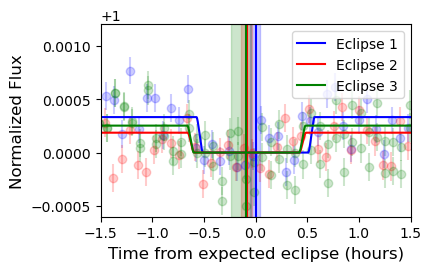

In [247]:
# reproduce above figure with only top panel
fig, ax = plt.subplots(1, 1, figsize=(4,2.5))   
#colors = {'1': '#00B9AE', '2': '#f87060', '3': '#235789'}  
colors = {'1': 'blue', '2': 'red', '3': 'green'}
astro = {e: [] for e in eclipses}
t_s = {e: [] for e in eclipses}

for e in eclipses:
    if e == '1':
       ts, fp, a, b, c, sigF = p0_mcmc[e]
       t_s[e] = ts + time[e][0]
       astro[e] = transit_model(time[e], t_s[e], fp)
       detec = exponential_func(bins_time[e]-time[e][0], a, b, c) 
       ax.plot(time[e], astro[e], color = colors[e], label='Eclipse 1')
       ax.errorbar(bins_time[e], bins_aplev[e]/detec, yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)
       ax.axvspan(t_s[e]-MCMC_Results[e][0][2], t_s[e]+MCMC_Results[e][0][1],color=colors[e], alpha=0.2)
       ax.axvline(t_s[e], color=colors[e])
    elif e == '2':
        a = 9.05030776e-05 
        b = -5.54250578e-04  
        c = 6.96441578e-04  
        d = 1.00011736e+00
        ts, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc[e]
        t_s[e] = ts + time[e][0]
        print(fp)
        astro[e] = transit_model(time[e], t_s[e], fp)
        detec1 = poly_3rd_degree(bins_time[e]-time[e][0], a, b, c, d)
        detec2 = detec_model_poly(bins_centroid_x[e], bins_centroid_y[e], c1, c2, c3, c4, c5, c6)
        detec = detec1*detec2
        ax.plot(time[e], astro[e], color = colors[e], label='Eclipse 2')
        ax.errorbar(bins_time[e], bins_aplev[e]/detec, yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)
        ax.axvline(t_s[e], color=colors[e])
        ax.axvspan(t_s[e]-MCMC_Results[e][0][2], t_s[e]+MCMC_Results[e][0][1],color=colors[e], alpha=0.2)
    elif e == '3':
        # define a, b, c, d
        a = 5.734895061096462e-05
        b = -0.0003312133992833888
        c = 0.0004085577908727154
        d = 1.0000901143792549
        ts, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc[e]
        t_s[e] = ts + time[e][0]
        print(t_s)
        astro[e] = transit_model(time[e], t_s[e], fp)
        detec1 = poly_3rd_degree(bins_time[e]-time[e][0], a, b, c, d)
        detec2 = detec_model_poly(bins_centroid_x[e], bins_centroid_y[e], c1, c2, c3, c4, c5, c6)
        detec = detec1*detec2
        ax.plot(time[e], astro[e], color = colors[e], label='Eclipse 3')
        ax.errorbar(bins_time[e], bins_aplev[e], yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)
        ax.errorbar(bins_time[e], bins_aplev[e]/detec, yerr=binErr_aplev[e], fmt='o', color = colors[e], alpha = 0.2, zorder = 1)
        ax.axvline(t_s[e], color=colors[e])
        ax.axvspan(t_s[e]-MCMC_Results[e][0][2],t_s[e]+MCMC_Results[e][0][1],color=colors[e], alpha=0.2)

ax.legend()
ax.set_ylabel('Normalized Flux', fontsize=12)
ax.set_xlabel('Time from expected eclipse (hours)', fontsize=12)
fig.subplots_adjust(hspace=0)
ax.set_ylim(0.9994, 1.0012)
ax.set_xlim(-1.5, 1.5)


## CHECK THAT time[0] is the same for all eclipses (removed first 2 pts) and that timing exact

In [223]:
# PLOT WITH CONCATENATED FLUXES (uncorrected)
time_combined = np.concatenate((time['1'], time['2'], time['3']))
flux_combined = np.concatenate((aplev['1'], aplev['2'], aplev['3']))
err_combined = np.concatenate((aperr['1'], aperr['2'], aperr['3']))
centroid_x_combined = np.concatenate((centroid_x['1'], centroid_x['2'], centroid_x['3']))
centroid_y_combined = np.concatenate((centroid_y['1'], centroid_y['2'], centroid_y['3']))
# sort the arrays by time
time_combined, flux_combined, err_combined, centroid_x_combined, centroid_y_combined = zip(*sorted(zip(time_combined, flux_combined, err_combined, centroid_x_combined, centroid_y_combined)))


In [229]:
# CONCATENATE FLUXES (corrected)
corrected_flux = {e: [] for e in eclipses}

for e in eclipses:
    if e == '1':
       t_s, fp, a, b, c, sigF = p0_mcmc[e]
       detec = exponential_func(time[e]-time[e][0], a, b, c) 
       corrected_flux[e] = aplev[e]/detec

    elif e == '2':
        a = 9.05030776e-05 
        b = -5.54250578e-04  
        c = 6.96441578e-04  
        d = 1.00011736e+00
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc[e]
        detec1 = poly_3rd_degree(time[e]-time[e][0], a, b, c, d)
        detec2 = detec_model_poly(centroid_x[e], centroid_y[e], c1, c2, c3, c4, c5, c6)
        detec = detec1*detec2
        corrected_flux[e] = aplev[e]/detec

    elif e == '3':
        # define a, b, c, d
        a = 5.734895061096462e-05
        b = -0.0003312133992833888
        c = 0.0004085577908727154
        d = 1.0000901143792549
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc[e]
        detec1 = poly_3rd_degree(time[e]-time[e][0], a, b, c, d)
        detec2 = detec_model_poly(centroid_x[e], centroid_y[e], c1, c2, c3, c4, c5, c6)
        detec = detec1*detec2
        corrected_flux[e] = aplev[e]/detec

time_combined = np.concatenate((time['1'], time['2'], time['3']))
flux_combined = np.concatenate((corrected_flux['1'], corrected_flux['2'], corrected_flux['3']))
err_combined = np.concatenate((aperr['1'], aperr['2'], aperr['3']))

<ErrorbarContainer object of 3 artists>

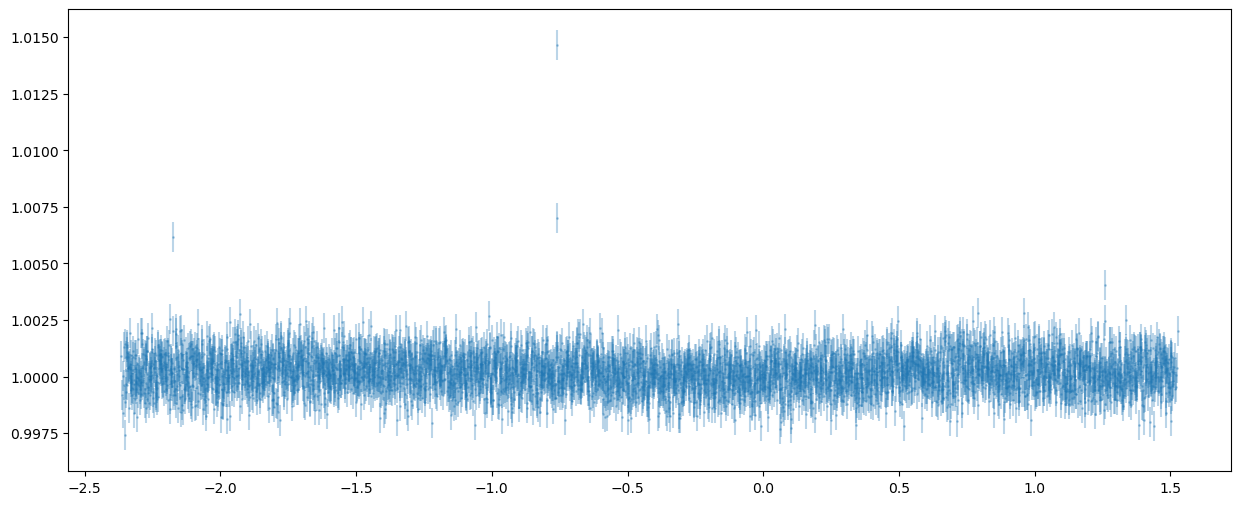

In [231]:
plt.figure(figsize=(15, 6))
plt.errorbar(time_combined, flux_combined, yerr=err_combined, fmt='o', markersize=1, alpha=0.3)

In [235]:
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

nbin = 50

bins_time_combined, binErr_t = binValues(time_combined, time_combined, nbin)
    #bins_time[e] = bins_time[e] - time[e][0]

In [236]:
def binValues(values, error, binAxisValues, nbin, assumeWhiteNoise=True):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binCounts = np.array([np.sum(digitized == i) for i in range(1, nbin)])

    binnedErr = np.array([np.mean(error[digitized == i]) for i in range(1, nbin)])/np.sqrt(binCounts)
    #binnedErr = np.array([np.sqrt(np.sum((error[digitized == i])**2))/(binCounts)  for i in range(1, nbin)]) 
    #binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))

    return binned, binnedErr


bins_flux_combined, binErr_flux_combined = binValues(flux_combined, err_combined, time_combined, nbin)

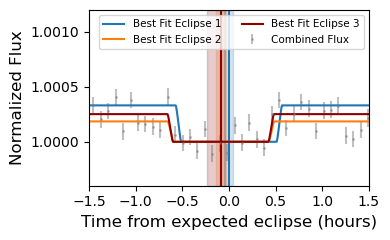

In [262]:
# reproduce above figure with only top panel
fig, ax = plt.subplots(1, 1, figsize=(4,2.5))   
colors = {'1': 'C0', '2': 'C1', '3': 'darkred'}

#colors = {'1': '#00B9AE', '2': '#f87060', '3': '#235789'}  

plt.errorbar(bins_time_combined, bins_flux_combined, yerr=binErr_flux_combined, fmt='o', color='grey', markersize=1, alpha=0.5, label = 'Combined Flux')

plt.xlabel('Time from expected eclipse (hours)', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)
for e in eclipses:
    plt.plot(time[e], astro[e], color = colors[e], label='Best Fit Eclipse '+e)
    plt.axvline(t_s[e], color=colors[e])
    plt.axvspan(t_s[e]-MCMC_Results[e][0][2],t_s[e]+MCMC_Results[e][0][1],color=colors[e], alpha=0.2)
plt.ylim(0.9996, 1.0012)
plt.ticklabel_format(useOffset=False)
plt.xlim(-1.5, 1.5)
plt.legend(ncols=2, prop={'size': 7.5})
plt.tight_layout()
plt.savefig('plots/lhs1140c.pdf')

In [212]:
def walk_style(chain, labels, interv=10, fname=None, showPlot=False, fontsize=15):
    """Make a plot showing the evolution of the walkers throughout the emcee sampling.
    Args:
        chain (ndarray): The ndarray accessed by calling sampler.chain when using emcee
        labels (ndarray): The fancy labels for each dimension
        interv (int): Take every 'interv' element to thin out the plot
        name (string, optional): The savepath for the plot (or None if you want to return the figure instead).
        showPlot (bool, optional): Whether or not you want to show the plotted figure.
    Returns:
        None

    """

    nwalk = chain.shape[0]
    ndim = chain.shape[-1]

    # get first index
    beg   = 0
    end   = len(chain[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv]

    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows

    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        sig1 = (0.6827)/2.*100
        sig2 = (0.9545)/2.*100
        sig3 = (0.9973)/2.*100
        percentiles = [50-sig3, 50-sig2, 50-sig1, 50, 50+sig1, 50+sig2, 50+sig3]
        neg3sig, neg2sig, neg1sig, mu_param, pos1sig, pos2sig, pos3sig = np.percentile(chain[:,:,ind][:,beg:end:interv],
                                                                                       percentiles, axis=0)
        plt.plot(step, mu_param)
        plt.fill_between(step, pos3sig, neg3sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos2sig, neg2sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos1sig, neg1sig, facecolor='k', alpha = 0.1)
        plt.title(labels[ind], fontsize=fontsize)
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)

        y_formatter = ScalarFormatter(useOffset=False)
        plt.gca().yaxis.set_major_formatter(y_formatter)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize*0.8)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize*0.8)

    if fname != None:
        plt.savefig(fname, bbox_inches='tight')

    if showPlot:
        plt.show()

    #plt.close()
    return

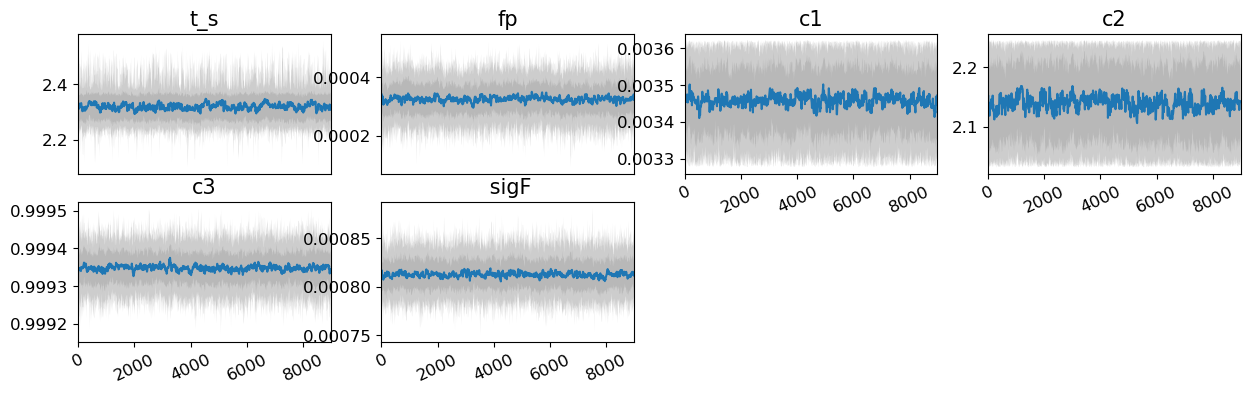

In [216]:
p0_labels = 't_s, fp, c1, c2, c3,  sigF'.split(', ')
walk_style(chain['1'], p0_labels, interv=10, showPlot=True, fontsize=15)